In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install keras-tuner


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 11.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from keras_tuner import RandomSearch
import seaborn as sns
import kerastuner as kt
from sklearn.metrics import confusion_matrix

<ipython-input-4-35de0081cb59>:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ravdess_folder_path = '/content/drive/MyDrive/IE Project/audio_speech_actors_01-24'

In [ ]:
def load_data_ravdess_raw_audio(directory):
    X = []
    y = []
    max_audio_length = 0
    
    for actor_dir in os.listdir(directory):
        actor_path = os.path.join(directory, actor_dir)
        if os.path.isdir(actor_path):
            for file in os.listdir(actor_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(actor_path, file)
                    emotion = int(file.split("-")[2])
                    y.append(emotion)
                    
                    audio, sr = librosa.load(file_path, sr=None) # Loaded with original sampling rate
                    
                    max_audio_length = max(max_audio_length, len(audio))
                    
                    X.append(audio)
    
    X = [np.pad(x, (0, max_audio_length - len(x)), 'constant') if len(x) < max_audio_length else x[:max_audio_length] for x in X]
                    
    return np.array(X), np.array(y)

Raw audio data consists of a continuous sequence of digital samples that represent the amplitude of an audio signal at specific points in time. These samples are taken at a fixed rate called the sampling rate, which determines the number of samples taken per second. The sampling rate is typically measured in Hertz (Hz), and higher sampling rates result in a more accurate representation of the original analog audio signal.

For example, a common sampling rate for digital audio is 44,100 Hz, which means that 44,100 samples are taken per second. Each sample is a numerical value that represents the amplitude of the audio waveform at a specific point in time.

In [ ]:
# X, y = load_data_ravdess_raw_audio(ravdess_folder_path)

In [ ]:
# np.save('/content/drive/MyDrive/IE Project/MLP (Ali)/X & y/X.npy', X)
# np.save('/content/drive/MyDrive/IE Project/MLP (Ali)/X & y/y.npy', y)

In [ ]:
X = np.load('/content/drive/MyDrive/IE Project/MLP (Ali)/X & y/X.npy')
y = np.load('/content/drive/MyDrive/IE Project/MLP (Ali)/X & y/y.npy')

Normalizing the input data and one-hot encoding the targets

In [ ]:
X.shape

(1440, 253053)

In [ ]:
X[0:5]

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.1552734e-05, 1.2207031e-04, 9.1552734e-05, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(X.shape[0], -1)).reshape(X.shape)

# One-hot encode the labels
encoder = OneHotEncoder()
y = encoder.fit_transform(y.reshape(-1, 1)).toarray()

In [ ]:
X.shape

(1440, 253053)

In [ ]:
X[0:5]

array([[0.40976462, 0.32462686, 0.29932886, ..., 0.        , 0.        ,
        0.        ],
       [0.41238013, 0.32761192, 0.30134228, ..., 0.        , 0.        ,
        0.        ],
       [0.40976462, 0.32462686, 0.29932886, ..., 0.        , 0.        ,
        0.        ],
       [0.40976462, 0.32462686, 0.29932886, ..., 0.        , 0.        ,
        0.        ],
       [0.40976462, 0.32462686, 0.29932886, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

Splitting data into test and valdiation sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
model = Sequential([
    Flatten(input_shape=(X_train.shape[1], 1)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 253053)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               64781824  
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 8)                 520       
                                                                 
Total params: 64,823,496
Trainable params: 64,823,496
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
27/27 [==============================] - 3s 75ms/step - loss: 35.1509 - accuracy: 0.1262 - val_loss: 26.2710 - val_accuracy: 0.1111
Epoch 2/50
27/27 [==============================] - 1s 31ms/step - loss: 21.0519 - accuracy: 0.1539 - val_loss: 12.3069 - val_accuracy: 0.1076
Epoch 3/50
27/27 [==============================] - 1s 31ms/step - loss: 12.3377 - accuracy: 0.1400 - val_loss: 11.5532 - val_accuracy: 0.0868
Epoch 4/50
27/27 [==============================] - 1s 31ms/step - loss: 13.5905 - accuracy: 0.1389 - val_loss: 17.2349 - val_accuracy: 0.1111
Epoch 5/50
27/27 [==============================] - 1s 41ms/step - loss: 10.9759 - accuracy: 0.1354 - val_loss: 6.3932 - val_accuracy: 0.1250
Epoch 6/50
27/27 [==============================] - 1s 41ms/step - loss: 4.8310 - accuracy: 0.1215 - val_loss: 3.2524 - val_accuracy: 0.1354
Epoch 7/50
27/27 [==============================] - 1s 31ms/step - loss: 2.6878 - accuracy: 0.1470 - val_loss: 3.1161 - val_accuracy: 0.1076
Epoc

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

9/9 [==============================] - 0s 16ms/step - loss: 2.4714 - accuracy: 0.1424
Test loss: 2.4714388847351074
Test accuracy: 0.1423611044883728


In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

9/9 [==============================] - 0s 13ms/step


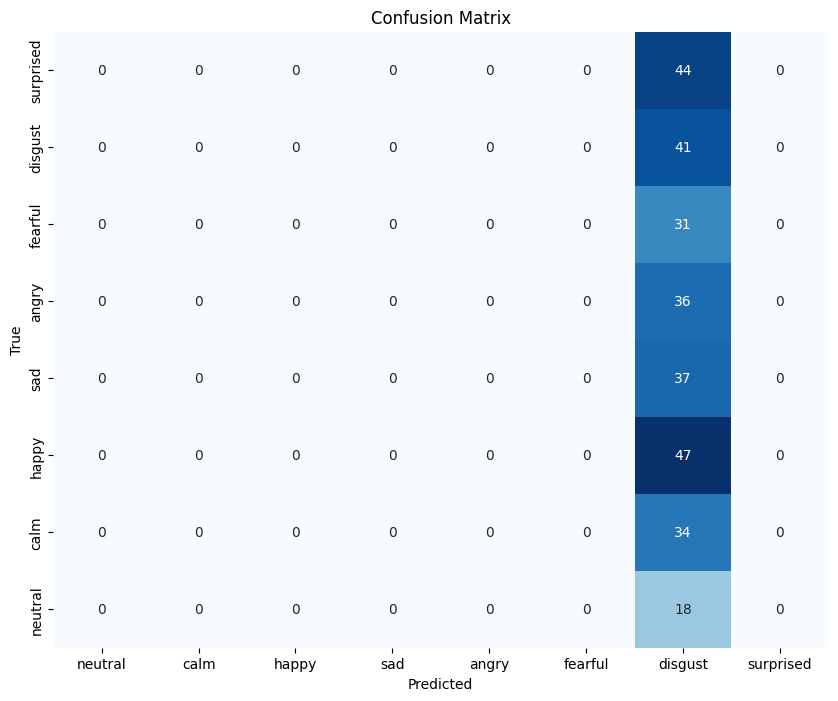

In [ ]:
y_pred = model.predict(X_test)

y_pred_indices = np.argmax(y_pred, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_indices, y_pred_indices)

cm_reordered = cm[::-1, :]

emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

plt.figure(figsize=(10, 8))
sns.heatmap(cm_reordered, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=emotion_labels, yticklabels=emotion_labels[::-1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Saved model

In [ ]:
model_save_path = '/content/drive/MyDrive/IE Project/MLP (Ali)/mlp_model1.h5'
model.save(model_save_path)

# Hyperparameter Tuning

In [ ]:
def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(X_train.shape[1], 1)),
        tf.keras.layers.Dense(units=hp.Int('units1', min_value=128, max_value=512, step=32), activation='relu'),
        tf.keras.layers.Dense(units=hp.Int('units2', min_value=64, max_value=256, step=32), activation='relu'),
        tf.keras.layers.Dense(units=hp.Int('units3', min_value=32, max_value=128, step=16), activation='relu'),
        tf.keras.layers.Dense(units=hp.Int('units4', min_value=16, max_value=64, step=8), activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld')

tuner.search_space_summary()

Search space summary
Default search space size: 5
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
units4 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 8, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Get the best model and its parameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters)

Trial 5 Complete [00h 01m 07s]
val_accuracy: 0.1493055522441864

Best val_accuracy So Far: 0.1597222238779068
Total elapsed time: 00h 06m 01s
Best hyperparameters: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7f01fadbfdf0>


In [ ]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

9/9 [==============================] - 0s 27ms/step - loss: 2.0653 - accuracy: 0.1632
Test loss: 2.0652811527252197
Test accuracy: 0.1631944477558136


# Tuning hyperparameters again with larger space



In [ ]:
def build_model2(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(X_train.shape[1], 1)),
        tf.keras.layers.Dense(units=hp.Int('units1', min_value=128, max_value=512, step=32), activation=hp.Choice('activation1', values=['relu', 'tanh', 'sigmoid'])),
        tf.keras.layers.Dropout(hp.Float('dropout1', min_value=0, max_value=0.5, step=0.1)),
        tf.keras.layers.Dense(units=hp.Int('units2', min_value=64, max_value=256, step=32), activation=hp.Choice('activation2', values=['relu', 'tanh', 'sigmoid'])),
        tf.keras.layers.Dropout(hp.Float('dropout2', min_value=0, max_value=0.5, step=0.1)),
        tf.keras.layers.Dense(units=hp.Int('units3', min_value=32, max_value=128, step=16), activation=hp.Choice('activation3', values=['relu', 'tanh', 'sigmoid'])),
        tf.keras.layers.Dropout(hp.Float('dropout3', min_value=0, max_value=0.5, step=0.1)),
        tf.keras.layers.Dense(units=hp.Int('units4', min_value=16, max_value=64, step=8), activation=hp.Choice('activation4', values=['relu', 'tanh', 'sigmoid'])),
        tf.keras.layers.Dropout(hp.Float('dropout4', min_value=0, max_value=0.5, step=0.1)),
        tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model


In [ ]:
tuner = RandomSearch(
    build_model2,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=2,
    directory='my_dir',
    project_name='helloworld2')

tuner.search_space_summary()

Search space summary
Default search space size: 13
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
activation2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
activation3 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}


In [ ]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Get the best model and its parameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters)

Trial 15 Complete [00h 00m 28s]
val_accuracy: 0.147569440305233

Best val_accuracy So Far: 0.1631944477558136
Total elapsed time: 00h 11m 46s
Best hyperparameters: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7f5c5f6d4e20>


In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]
hp_dict = best_hyperparameters.values

print("Best Hyperparameters:")
for key, value in hp_dict.items():
    print(f"{key}: {value}")

Best Hyperparameters:
units1: 512
activation1: sigmoid
dropout1: 0.0
units2: 256
activation2: tanh
dropout2: 0.4
units3: 48
activation3: tanh
dropout3: 0.2
units4: 56
activation4: tanh
dropout4: 0.1
learning_rate: 0.01


In [ ]:
best_model.save('/content/drive/MyDrive/IE Project/MLP (Ali)/bestmodel_nofeat.h5')

# Feature Extraction

In [ ]:
def extract_features_from_array(X, sr=22050):
    feature_list = []

    for audio_data in X:
        # Reshape audio data to 1D
        audio_data = audio_data.reshape(-1)

        # MFCCs
        mfcc = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)

        # Chroma features
        chroma_stft = librosa.feature.chroma_stft(y=audio_data, sr=sr)

        # Spectral contrast
        spec_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sr)

        # Tonnetz
        tonnetz = librosa.feature.tonnetz(y=audio_data, sr=sr)

        # Pitch (F0)
        pitches, _ = librosa.core.piptrack(y=audio_data, sr=sr)
        pitch = np.max(pitches, axis=0)

        # RMS energy
        rms = librosa.feature.rms(y=audio_data)

        # Stack all features
        features = np.vstack([mfcc, chroma_stft, spec_contrast, tonnetz, pitch, rms])

        feature_list.append(features)

    return np.array(feature_list)

In [ ]:
# Extract features from X
X_features = extract_features_from_array(X)

In [ ]:
folder_path = '/content/drive/MyDrive/IE Project/MLP (Ali)/X & y'
file_name = 'X_features.npy'

In [ ]:
X_features = np.load(f'{folder_path}/{file_name}')

# Model with extracted features

In [ ]:
X_features.shape

(1440, 40, 495)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
# Calculate the input shape (number of features)
input_shape = X

In [ ]:
model = Sequential([
    Flatten(input_shape=input_shape),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64, callbacks=[early_stopping],verbose=1)

Epoch 1/100
14/14 [==============================] - 2s 23ms/step - loss: 279.9738 - accuracy: 0.1262 - val_loss: 243.3817 - val_accuracy: 0.1146
Epoch 2/100
14/14 [==============================] - 0s 9ms/step - loss: 166.3062 - accuracy: 0.1736 - val_loss: 128.7157 - val_accuracy: 0.1944
Epoch 3/100
14/14 [==============================] - 0s 10ms/step - loss: 80.8454 - accuracy: 0.1806 - val_loss: 88.8497 - val_accuracy: 0.2188
Epoch 4/100
14/14 [==============================] - 0s 8ms/step - loss: 72.2168 - accuracy: 0.1840 - val_loss: 91.0828 - val_accuracy: 0.1771
Epoch 5/100
14/14 [==============================] - 0s 9ms/step - loss: 78.4194 - accuracy: 0.1933 - val_loss: 62.8302 - val_accuracy: 0.1424
Epoch 6/100
14/14 [==============================] - 0s 9ms/step - loss: 60.4116 - accuracy: 0.1806 - val_loss: 49.1290 - val_accuracy: 0.1562
Epoch 7/100
14/14 [==============================] - 0s 9ms/step - loss: 45.2832 - accuracy: 0.2188 - val_loss: 81.2293 - val_accuracy: 

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

9/9 [==============================] - 0s 3ms/step - loss: 6.8765 - accuracy: 0.2500
Test loss: 6.876497268676758
Test accuracy: 0.25


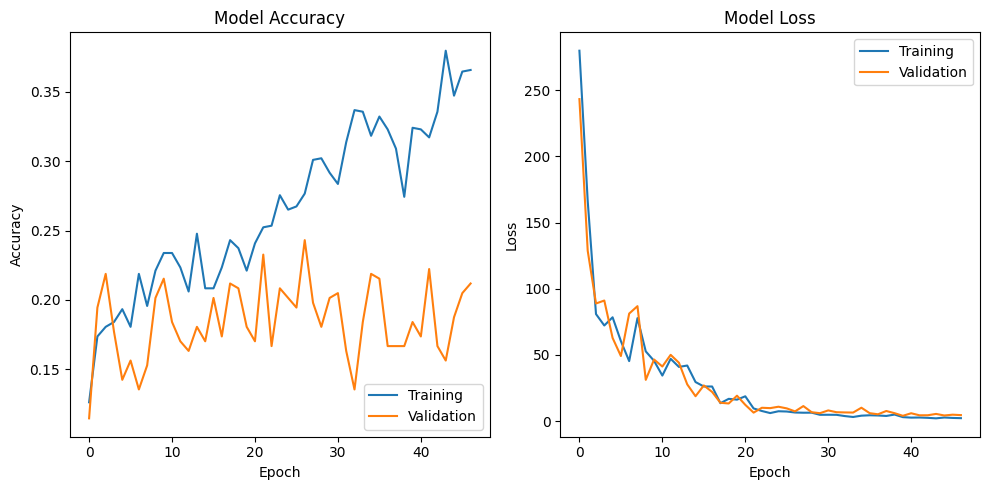

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

9/9 [==============================] - 0s 2ms/step


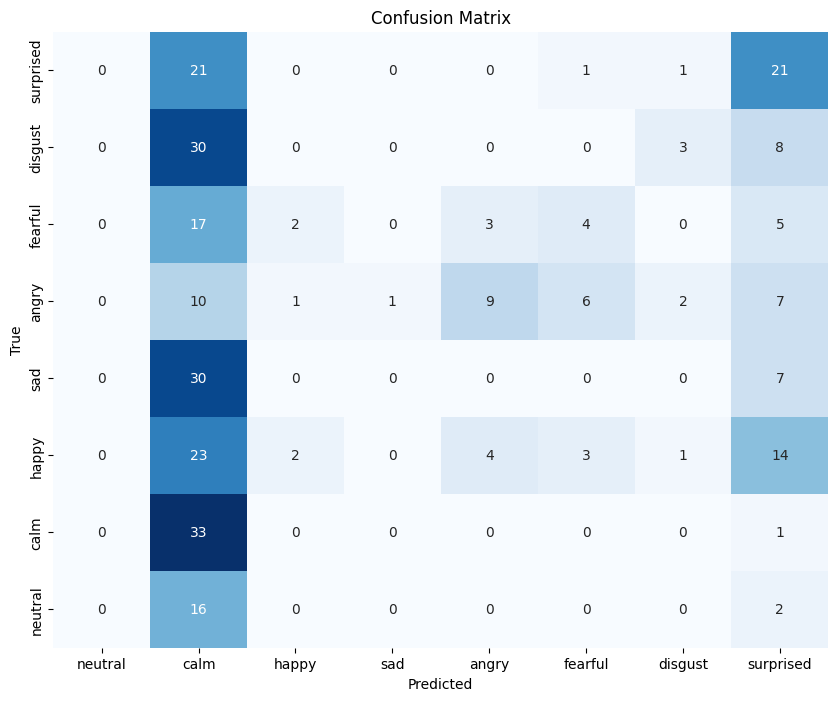

In [ ]:
y_pred = model.predict(X_test)

y_pred_indices = np.argmax(y_pred, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_indices, y_pred_indices)

cm_reordered = cm[::-1, :]

emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

plt.figure(figsize=(10, 8))
sns.heatmap(cm_reordered, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=emotion_labels, yticklabels=emotion_labels[::-1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Hyperparameter Tuning with Extracted Features

In [ ]:
def build_model(hp):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(units=hp.Int('dense_1_units', min_value=128, max_value=512, step=64), activation='relu'),
        Dropout(rate=hp.Float('dropout_1_rate', min_value=0.1, max_value=0.5, step=0.1)),
        Dense(units=hp.Int('dense_2_units', min_value=64, max_value=256, step=32), activation='relu'),
        Dropout(rate=hp.Float('dropout_2_rate', min_value=0.1, max_value=0.5, step=0.1)),
        Dense(units=hp.Int('dense_3_units', min_value=32, max_value=128, step=16), activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    seed=42,
    directory='tuning',
    project_name='tuned_model'
)

tuner.search_space_summary()

Search space summary
Default search space size: 5
dense_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
dropout_1_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_2_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_3_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}


In [ ]:
tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Trial 50 Complete [00h 00m 04s]
val_accuracy: 0.1840277761220932

Best val_accuracy So Far: 0.2326388955116272
Total elapsed time: 00h 04m 05s


In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = build_model(best_hp)
best_model.summary()

history = best_model.fit(X_train, y_train, epochs=40, validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

# Evaluate the model on the test set
_, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 19800)             0         
                                                                 
 dense_8 (Dense)             (None, 512)               10138112  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 96)                49248     
                                                                 
 dropout_5 (Dropout)         (None, 96)                0         
                                                                 
 dense_10 (Dense)            (None, 80)                7760      
                                                                 
 dense_11 (Dense)            (None, 8)                